In [1]:
#Setting matplotlib to be inline
%matplotlib inline

#Importing the necessary libraries
from os import listdir
from os.path import isfile, join

import re
import csv

import pandas as pd

from pylab import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Set the root directory
root_dir = '.';

In [2]:
###
#These are functions to be used here.
###
##Function to change bar plot's bar width.
def change_barwidth(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [3]:
#Set the data directory
data_file = '';

#Printing file list
fileList = [f for f in listdir(root_dir) if f.endswith(".csv")]
print("Data files:")
print("\n".join(fileList))

Data files:
FromPaperFromTree_Yarrowia_CAAX-Asn_CVIA-best_pairID.csv
ML16507_Pher-deletions_190507.csv
Ylipo_filter-mating.csv
Ylipo_filter-mating_181211-v2.csv
Ylipo_filter-mating_181211.csv
Ylipo_filter-mating_190423.csv
Ylipo_filter-mating_190917.csv
Ylipo_TransExpr_180802.csv


In [4]:
rawMatingData = pd.read_csv('Ylipo_filter-mating.csv')
print(rawMatingData.iloc[0])

Expt Date            20180801/0804
Plasmid                       Null
Strain                 ML16507/YPD
Replicate                        1
Partner Inoculum               NaN
Inoculum count                 NaN
Plated Cell count          1.3e+08
Plate/2e07                     NaN
Plate/1e07                     NaN
Plate/5e06                     440
Plate/2e06                     180
Plate/1e06                     NaN
Contamination                  NaN
YM date                   20180730
BSA                            NaN
Name: 0, dtype: object


In [5]:
rawMatingData = pd.read_csv('Ylipo_filter-mating.csv')
MatingData = rawMatingData ##The problem is this links the two variables rather than creating a new variable on which I work.
#MatingData (int(1e08), axis='Plated Cell count')
#MatingData['Plated Cell count'] = (rawMatingData['Plated Cell count']/int(1e08))
MatingData['Plated Cell count'] /= int(1e08)
#print(MatingData['Plated Cell count'])
print(MatingData.iloc[0])

Expt Date            20180801/0804
Plasmid                       Null
Strain                 ML16507/YPD
Replicate                        1
Partner Inoculum               NaN
Inoculum count                 NaN
Plated Cell count              1.3
Plate/2e07                     NaN
Plate/1e07                     NaN
Plate/5e06                     440
Plate/2e06                     180
Plate/1e06                     NaN
Contamination                  NaN
YM date                   20180730
BSA                            NaN
Name: 0, dtype: object


In [6]:
##I am going to re-scale the colony counts to be colonies/1e06cells plated. I am going to multiply the values accordingly.
#print(int(float(MatingData.columns[7].split("/")[-1]))/int(1e06))
rawMatingData = pd.read_csv('Ylipo_filter-mating.csv')
MatingData = rawMatingData
MatingData['Plated Cell count'] /= int(1e08)

##Normalization of colony counts based on the estimated cells plated.
for column in MatingData.columns:
    if column.split("/")[0] == "Plate":
        MatingData[column] /= (int(float(column.split("/")[-1]))/int(1e06));
#print(MatingData.iloc[0])
#print(rawMatingData.iloc[0])
#print(MatingData['Plate/5e06'])

##Normalization based on the plated cells in each experiment.
for index in list(MatingData.index.values):
    MatingData.loc[index, ['Plate/2e07','Plate/1e07','Plate/5e06','Plate/2e06','Plate/1e06']] /= float(MatingData.loc[index, 'Plated Cell count'])

plotIDTemp = []
for index in list(MatingData.index.values):
    plotIDTemp.append(str(str(MatingData['Plasmid'].iloc[index])+"/"+str(MatingData['Strain'].iloc[index])))
#print(len(plotIDTemp))

MatingData.insert(3, "plotID", plotIDTemp)
print(MatingData.iloc[0])

Expt Date               20180801/0804
Plasmid                          Null
Strain                    ML16507/YPD
plotID               Null/ML16507/YPD
Replicate                           1
Partner Inoculum                  NaN
Inoculum count                    NaN
Plated Cell count                 1.3
Plate/2e07                        NaN
Plate/1e07                        NaN
Plate/5e06                    67.6923
Plate/2e06                    69.2308
Plate/1e06                        NaN
Contamination                     NaN
YM date                      20180730
BSA                               NaN
Name: 0, dtype: object


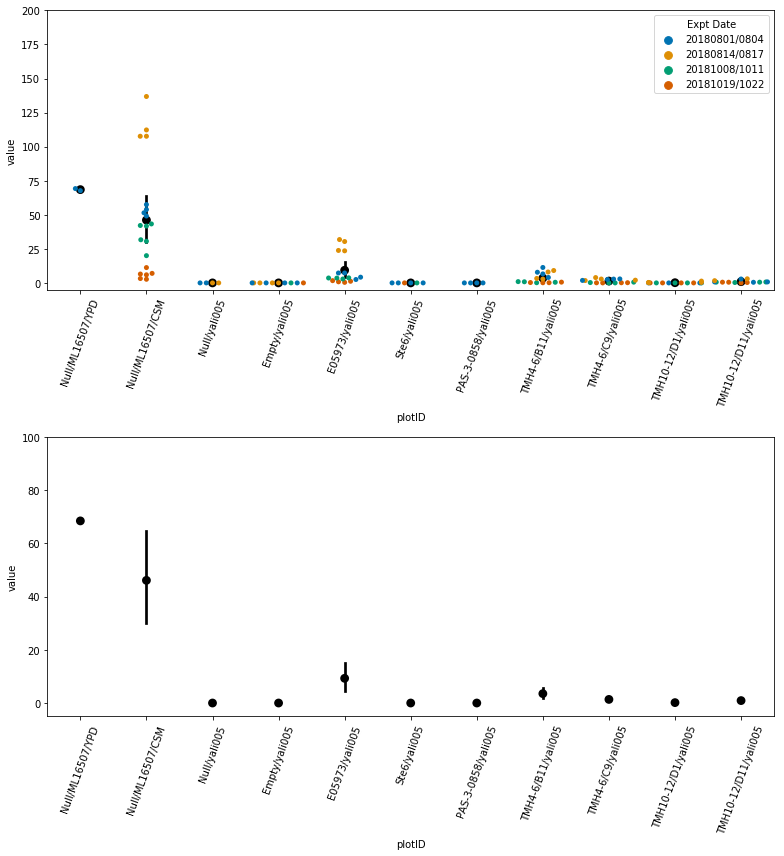

In [8]:
plotMatingData = MatingData[['Expt Date', 'plotID', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06', 'Plate/2e06', 
                             'Plate/1e06']]
#print(plotMatingData.iloc[0])

meltedPlotMatingData = pd.melt(plotMatingData, id_vars=['Expt Date', 'plotID', 'Replicate'])
#print(meltedPlotMatingData)
fig1 = figure(figsize=(11,12))
ax1 = subplot(211)
ax1 = sns.pointplot(x="plotID", y="value", data=meltedPlotMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=meltedPlotMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=200, bottom=-5)
plt.xticks(rotation=70)

ax2 = subplot(212)
ax2 = sns.pointplot(x="plotID", y="value", data=meltedPlotMatingData, color="black", marker="d", join=False)
ax2.set(yscale='linear')
ax2.set_ylim(top=100, bottom=-5)
plt.xticks(rotation=70)
plt.tight_layout()
#savefig(root_dir+'/All-data.pdf', dpi=300, transparent=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

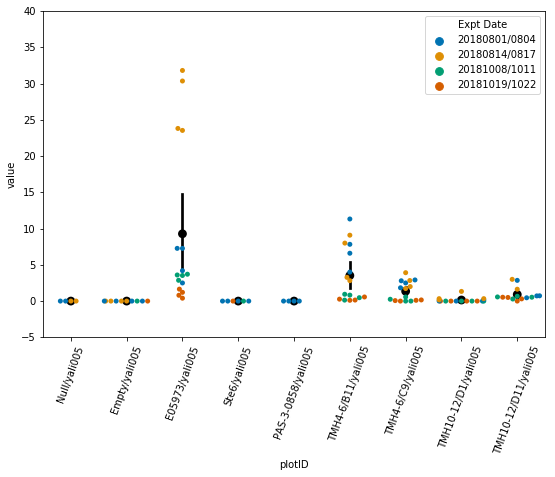

In [9]:
##Only plasmid containing sample to be plotted, by separating on the Strain name being yaliSS005.
refinedMatingData = MatingData.groupby(['Strain']).get_group("yali005")
#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'plotID', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'plotID', 'Replicate'])
#print(len(meltedPlotRefinedMatingData.index))

fig2 = figure(figsize=(9,6))
ax1 = sns.pointplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=40, bottom=-5)
plt.xticks(rotation=70)
#savefig(root_dir+'/PMB8369-plasmids_yali005_filter-mating.pdf', dpi=300, transparent=True)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

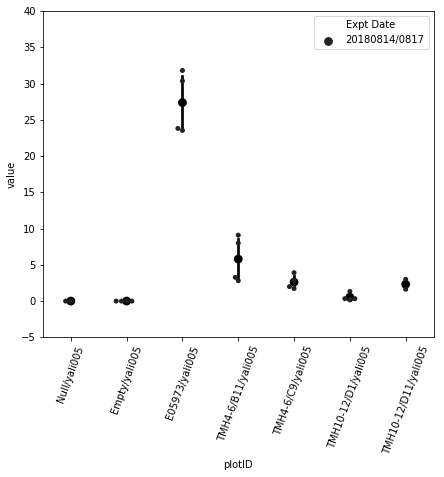

In [10]:
##Only plasmid containing sample to be plotted, by separating on the Strain name being yaliSS005.
refinedMatingData = (MatingData.groupby(['Strain']).get_group("yali005")).groupby(['Expt Date']).get_group("20180814/0817")
#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'plotID', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'plotID', 'Replicate'])
#testColor = Color()


fig2 = figure(figsize=(7,6))
#ax1 = subplot(211)
ax1 = sns.pointplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, 
                    color=sns.color_palette("colorblind")[1])
ax1.set(yscale='linear')
ax1.set_ylim(top=40, bottom=-5)
plt.xticks(rotation=70)

#ax2 = subplot(212)
#ax2 = sns.pointplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
#ax2 = sns.violinplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, )
#ax2.set(yscale='linear')
#ax2.set_ylim(top=60, bottom=-2)
#plt.xticks(rotation=70)
#plt.tight_layout()
#savefig(root_dir+'/8369-yali005_filter-mating_180814-0817.pdf', dpi=300, transparent=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

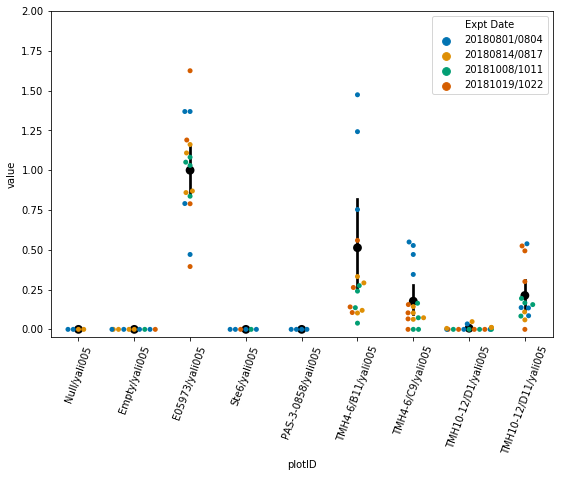

In [11]:
#################See below for updated version.
##Only plasmid containing sample to be plotted, by separating on the Strain name being yaliSS005.
##I am going to Normalize each experiment by the colonies of the [E05973-PMB8369]/yali005 in that experiment.
refinedMatingData = MatingData.groupby(['Strain']).get_group("yali005")

#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'plotID', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'plotID', 'Replicate'])

test = meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005")
#print(test)
Normalization = {}

for sample in test['Expt Date'].unique():
    #print(sample)
    Normalization.update({sample: test.groupby(['Expt Date']).get_group(sample)['value'].mean()})

#print(Normalization)

for index in list(meltedPlotRefinedMatingData.index.values):
    meltedPlotRefinedMatingData.loc[index, 'value'] /= Normalization[meltedPlotRefinedMatingData.loc[index, 'Expt Date']]

#print(meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005"))

fig2 = figure(figsize=(9,6))
ax1 = sns.pointplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/PMB8369-plasmids_yali005_filter-mating.pdf', dpi=300, transparent=True)

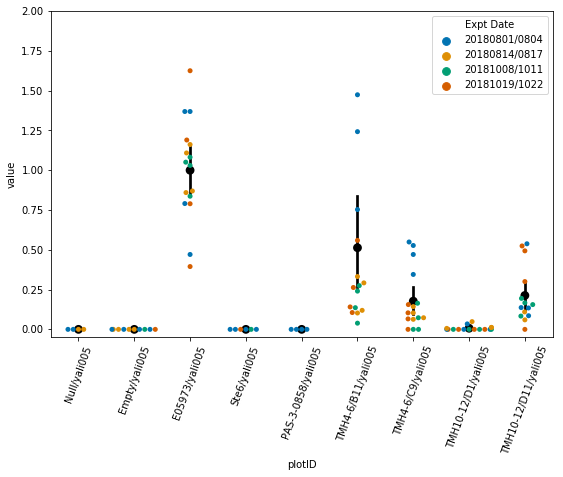

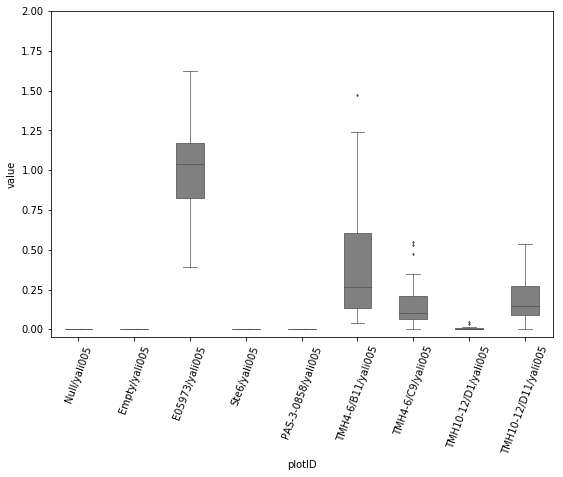

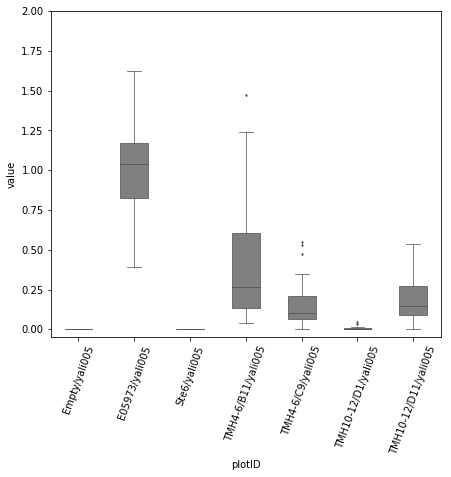

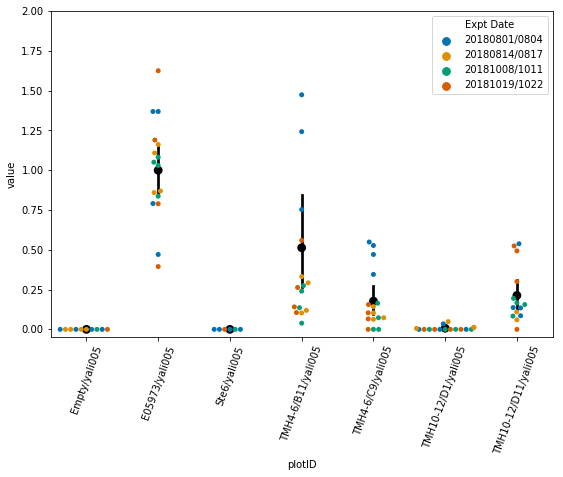

In [12]:
##Only plasmid containing sample to be plotted, by separating first on yali005 and then on the Expt Date since this is going to be the way I do things going forward.
##I am going to Normalize each experiment by the colonies of the [E05973-PMB8369]/yali005 in that experiment.
sortList = ["20180801/0804","20180814/0817","20181008/1011","20181019/1022"]
refinedMatingData = pd.DataFrame()
tempMatingData = MatingData.groupby(['Strain']).get_group("yali005")
for name in sortList:
    refinedMatingData = refinedMatingData.append(tempMatingData.groupby(['Expt Date']).get_group(name))

#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'plotID', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'plotID', 'Replicate'])

test = meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005")
#print(test)
Normalization = {}

for sample in test['Expt Date'].unique():
    #print(sample)
    Normalization.update({sample: test.groupby(['Expt Date']).get_group(sample)['value'].mean()})

#print(Normalization)

for index in list(meltedPlotRefinedMatingData.index.values):
    meltedPlotRefinedMatingData.loc[index, 'value'] /= Normalization[meltedPlotRefinedMatingData.loc[index, 'Expt Date']]

#print(meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005"))

fig1 = figure(figsize=(9,6))
ax1 = sns.pointplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/PMB8369-plasmids_yali005_filter-mating.pdf', dpi=300, transparent=True)

fig2 = figure(figsize=(9,6))
ax2 = sns.boxplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="grey", width=0.5, linewidth=0.7, fliersize=1.5)
ax2.set(yscale='linear')
ax2.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/PMB8369-plasmids_yali005_filter-mating_box-plot_190124.pdf', dpi=300, transparent=True)

##Only picking the samples needed for the paper's figure.
sortList = ["Empty/yali005","E05973/yali005","Ste6/yali005","TMH4-6/B11/yali005","TMH4-6/C9/yali005","TMH10-12/D1/yali005","TMH10-12/D11/yali005"]
subsetPlotData = pd.DataFrame()
for name in sortList:
    subsetPlotData = subsetPlotData.append(meltedPlotRefinedMatingData.groupby(['plotID']).get_group(name))
#print(subsetPlotData)

fig3 = figure(figsize=(7,6))
ax3 = sns.boxplot(x="plotID", y="value", data=subsetPlotData, color="grey", width=0.5, linewidth=0.7, fliersize=1.5)
ax3.set(yscale='linear')
ax3.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/PMB8369-plasmids_yali005_filter-mating_box-plot_subset_190124.pdf', dpi=300, transparent=True)

fig4 = figure(figsize=(9,6))
ax1 = sns.pointplot(x="plotID", y="value", data=subsetPlotData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=subsetPlotData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/PMB8369-plasmids_yali005_filter-mating_swarm_subset_190506.pdf', dpi=300, transparent=True)

#de8f05


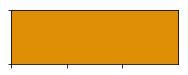

In [10]:
print(sns.color_palette("colorblind").as_hex()[1])
sns.palplot(sns.color_palette("colorblind")[1])

##This is for the plasmid samples with single-mutation containing plasmids.

In [4]:
##This is to include the transporter single-mutants.

##I am going to re-scale the colony counts to be colonies/1e06cells plated. I am going to multiply the values accordingly.
#print(int(float(MatingData.columns[7].split("/")[-1]))/int(1e06))
#rawMatingData = pd.read_csv('Ylipo_filter-mating_181211.csv')
rawMatingData = pd.read_csv('Ylipo_filter-mating_190917.csv')
MatingData = rawMatingData
MatingData['Plated Cell count'] /= int(1e08)

##Normalization of colony counts based on the estimated cells plated.
for column in MatingData.columns:
    if column.split("/")[0] == "Plate":
        MatingData[column] /= (int(float(column.split("/")[-1]))/int(1e06));
#print(MatingData.iloc[0])
#print(rawMatingData.iloc[0])
#print(MatingData['Plate/5e06'])

##Normalization based on the plated cells in each experiment.
for index in list(MatingData.index.values):
    MatingData.loc[index, ['Plate/2e07','Plate/1e07','Plate/5e06','Plate/2e06','Plate/1e06']] /= float(MatingData.loc[index, 'Plated Cell count'])

plotIDTemp = []
for index in list(MatingData.index.values):
    plotIDTemp.append(str(str(MatingData['Plasmid'].iloc[index])+"/"+str(MatingData['Strain'].iloc[index])))
#print(len(plotIDTemp))

MatingData.insert(3, "plotID", plotIDTemp)
print(MatingData.iloc[-1])

Expt Date                        20190806/0809
Plasmid                         TMH10-12/E991G
Strain                                 yali005
plotID                  TMH10-12/E991G/yali005
Genotype             Ylste6?;YlSte6/E991G(CEN)
Replicate                                    2
Partner Inoculum                       7.2e+07
Inoculum count                         2.3e+08
Plated Cell count                         0.94
Plate/2e07                             2.71277
Plate/1e07                                 NaN
Plate/5e06                             2.76596
Plate/2e06                                 NaN
Plate/1e06                                 NaN
Contamination                              NaN
YM date                               20190802
BSA                                       0.02
Liq                                      False
Name: 123, dtype: object


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

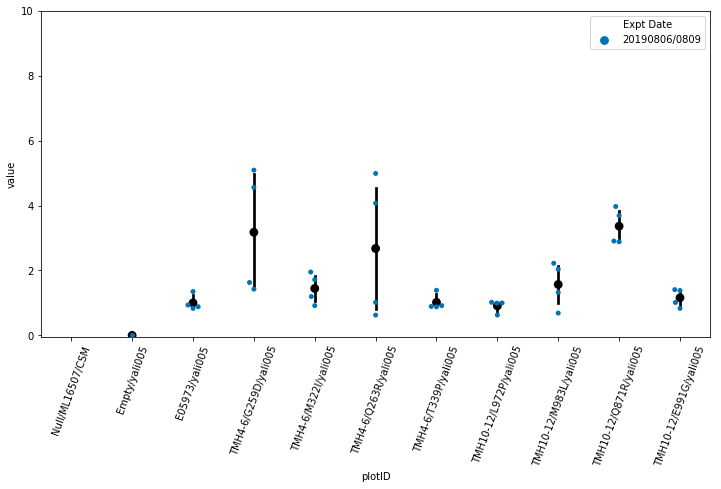

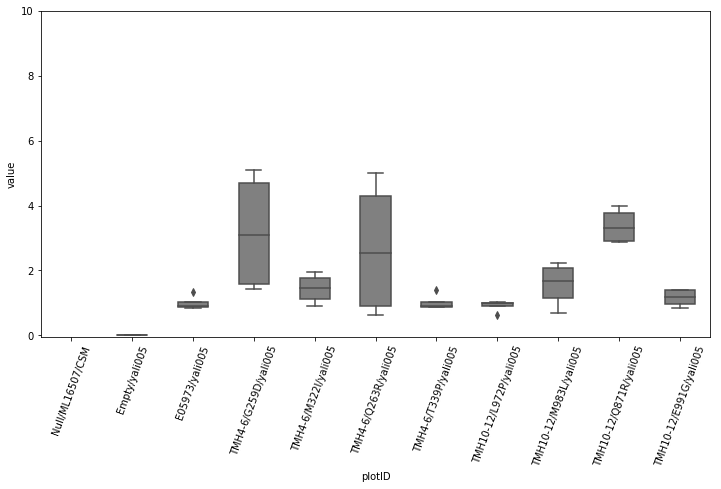

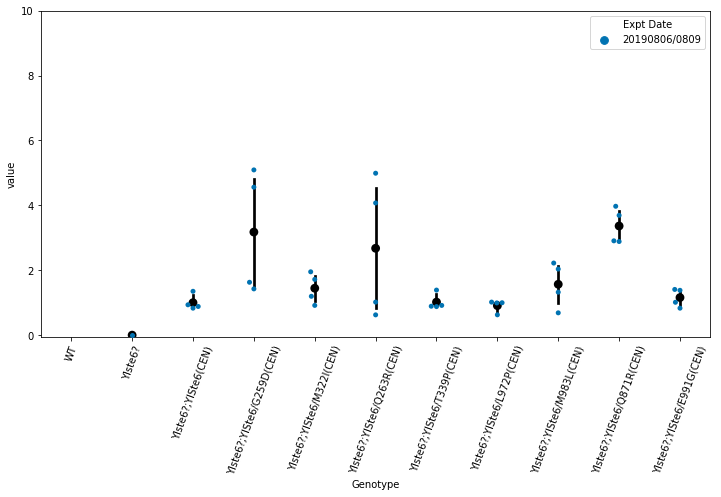

In [10]:
##This is for the plotting of the pheromone deletions, by separating on the appropriate Expt Date since this is going to be the way I do things going forward.
##I am going to Normalize each experiment by the colonies of the ML16507 (keep in mind I need to change the way media is specificied in my RawData (new column?))in that experiment.
sortList = ["20190806/0809"]
refinedMatingData = pd.DataFrame()
for name in sortList:
    refinedMatingData = refinedMatingData.append(MatingData.groupby(['Expt Date']).get_group(name))

##I am going to use 'Strain', instead of 'plotID' since I am not using plasmids here.
#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'plotID', 'Genotype', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'plotID', 'Genotype', 'Replicate'])

test = meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005")
#print(test)
Normalization = {}

for sample in test['Expt Date'].unique():
    #print(sample)
    Normalization.update({sample: test.groupby(['Expt Date']).get_group(sample)['value'].mean()})

#print(Normalization)

for index in list(meltedPlotRefinedMatingData.index.values):
    meltedPlotRefinedMatingData.loc[index, 'value'] /= Normalization[meltedPlotRefinedMatingData.loc[index, 'Expt Date']]

#print(meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005"))

fig1 = figure(figsize=(12,6))
ax1 = sns.pointplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="plotID", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=10.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating-v2.pdf', dpi=300, transparent=True)

fig2 = figure(figsize=(12,6))
ax2 = sns.boxplot(x="plotID", y="value", data=meltedPlotRefinedMatingData, color="grey", width=0.5)
ax2.set(yscale='linear')
ax2.set_ylim(top=10.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating-v2_box-plot_190124.pdf', dpi=300, transparent=True)

fig3 = figure(figsize=(12,6))
ax1 = sns.pointplot(x="Genotype", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="Genotype", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=10.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating_190506.pdf', dpi=300, transparent=True)

In [11]:
##I am going to re-scale the colony counts to be colonies/1e06cells plated. I am going to multiply the values accordingly.
#print(int(float(MatingData.columns[7].split("/")[-1]))/int(1e06))
#rawMatingData = pd.read_csv('Ylipo_filter-mating_181211.csv')
rawMatingData = pd.read_csv('Ylipo_filter-mating_181211-v2.csv')
MatingData = rawMatingData
MatingData['Plated Cell count'] /= int(1e08)

##Normalization of colony counts based on the estimated cells plated.
for column in MatingData.columns:
    if column.split("/")[0] == "Plate":
        MatingData[column] /= (int(float(column.split("/")[-1]))/int(1e06));
#print(MatingData.iloc[0])
#print(rawMatingData.iloc[0])
#print(MatingData['Plate/5e06'])

##Normalization based on the plated cells in each experiment.
for index in list(MatingData.index.values):
    MatingData.loc[index, ['Plate/2e07','Plate/1e07','Plate/5e06','Plate/2e06','Plate/1e06']] /= float(MatingData.loc[index, 'Plated Cell count'])

plotIDTemp = []
for index in list(MatingData.index.values):
    plotIDTemp.append(str(str(MatingData['Plasmid'].iloc[index])+"/"+str(MatingData['Strain'].iloc[index])))
#print(len(plotIDTemp))

MatingData.insert(3, "plotID", plotIDTemp)
print(MatingData.iloc[-1])

Expt Date                  20181122/1125
Plasmid                             Null
Strain                    Yl mfa2?;mfa3?
plotID               Null/Yl mfa2?;mfa3?
Replicate                              4
Partner Inoculum                 9.3e+07
Inoculum count                     1e+08
Plated Cell count                    1.4
Plate/2e07                           NaN
Plate/1e07                       28.1429
Plate/5e06                       28.5714
Plate/2e06                           NaN
Plate/1e06                           NaN
Contamination                        NaN
YM date                         20181015
BSA                                  NaN
Liq                                False
Name: 88, dtype: object


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

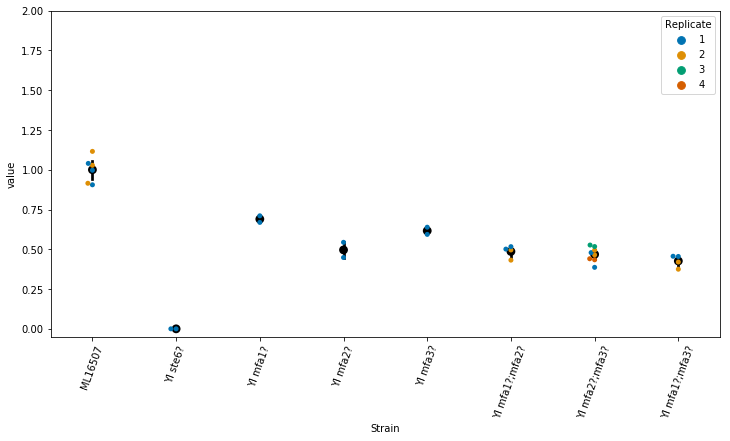

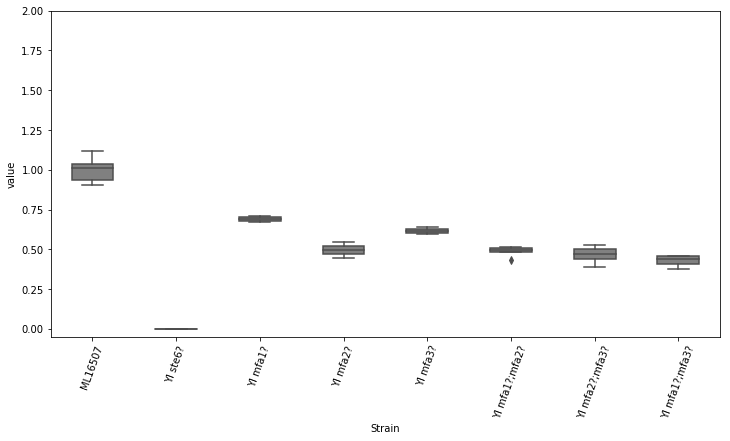

In [12]:
##This is for the plotting of the pheromone deletions, by separating on the appropriate Expt Date since this is going to be the way I do things going forward.
##I am going to Normalize each experiment by the colonies of the ML16507 (keep in mind I need to change the way media is specificied in my RawData (new column?))in that experiment.
sortList = ["20181122/1125"]
refinedMatingData = pd.DataFrame()
for name in sortList:
    refinedMatingData = refinedMatingData.append(MatingData.groupby(['Expt Date']).get_group(name))

##I am going to use 'Strain', instead of 'plotID' since I am not using plasmids here.
#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'Strain', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'Strain', 'Replicate'])

test = meltedPlotRefinedMatingData.groupby(['Strain']).get_group("ML16507")
#print(test)
Normalization = {}

for sample in test['Expt Date'].unique():
    #print(sample)
    Normalization.update({sample: test.groupby(['Expt Date']).get_group(sample)['value'].mean()})

#print(Normalization)

for index in list(meltedPlotRefinedMatingData.index.values):
    meltedPlotRefinedMatingData.loc[index, 'value'] /= Normalization[meltedPlotRefinedMatingData.loc[index, 'Expt Date']]

#print(meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005"))

fig1 = figure(figsize=(12,6))
ax1 = sns.pointplot(x="Strain", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="Strain", y="value", hue="Replicate", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating-v2.pdf', dpi=300, transparent=True)

fig2 = figure(figsize=(12,6))
ax2 = sns.boxplot(x="Strain", y="value", data=meltedPlotRefinedMatingData, color="grey", width=0.5)
ax2.set(yscale='linear')
ax2.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating-v2_box-plot_190124.pdf', dpi=300, transparent=True)

##This is to include the triple mutant of Pher01,02,03

In [8]:
##This is to include the triple mutant of Pher01,02,03
##I am going to re-scale the colony counts to be colonies/1e06cells plated. I am going to multiply the values accordingly.
#print(int(float(MatingData.columns[7].split("/")[-1]))/int(1e06))
#rawMatingData = pd.read_csv('Ylipo_filter-mating_181211.csv')
rawMatingData = pd.read_csv('Ylipo_filter-mating_190423.csv')
MatingData = rawMatingData
MatingData['Plated Cell count'] /= int(1e08)

##Normalization of colony counts based on the estimated cells plated.
for column in MatingData.columns:
    if column.split("/")[0] == "Plate":
        MatingData[column] /= (int(float(column.split("/")[-1]))/int(1e06));
#print(MatingData.iloc[0])
#print(rawMatingData.iloc[0])
#print(MatingData['Plate/5e06'])

##Normalization based on the plated cells in each experiment.
for index in list(MatingData.index.values):
    MatingData.loc[index, ['Plate/2e07','Plate/1e07','Plate/5e06','Plate/2e06','Plate/1e06']] /= float(MatingData.loc[index, 'Plated Cell count'])

plotIDTemp = []
for index in list(MatingData.index.values):
    plotIDTemp.append(str(str(MatingData['Plasmid'].iloc[index])+"/"+str(MatingData['Strain'].iloc[index])))
#print(len(plotIDTemp))

MatingData.insert(3, "plotID", plotIDTemp)
print(MatingData.iloc[-1])

Expt Date                   20190411/0414
Plasmid                              Null
Strain                            yali032
plotID                       Null/yali032
Genotype             Yl mfa1?;mfa2?;mfa3?
Replicate                               2
Partner Inoculum                  9.9e+07
Inoculum count                      9e+07
Plated Cell count                     1.4
Plate/2e07                            NaN
Plate/1e07                        72.9286
Plate/5e06                        74.2857
Plate/2e06                            NaN
Plate/1e06                            NaN
Contamination                         NaN
YM date                          20181015
BSA                                  0.02
Liq                                 False
Name: 103, dtype: object


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

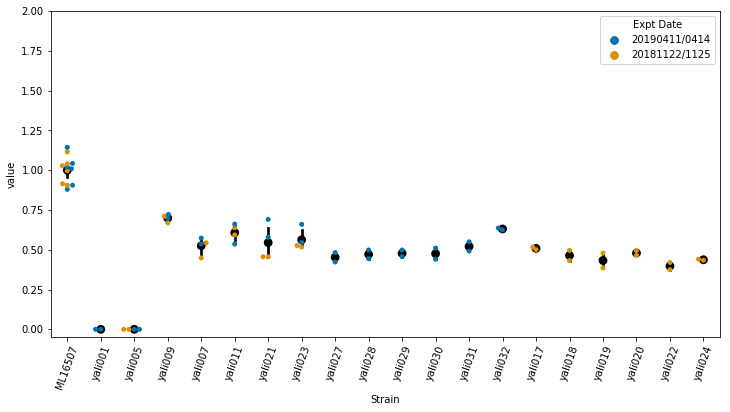

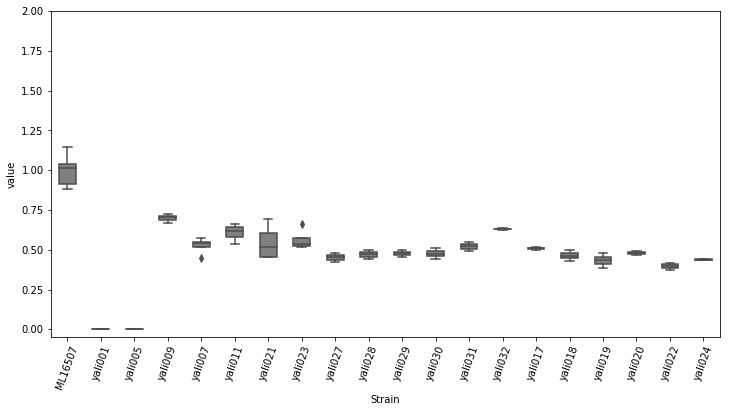

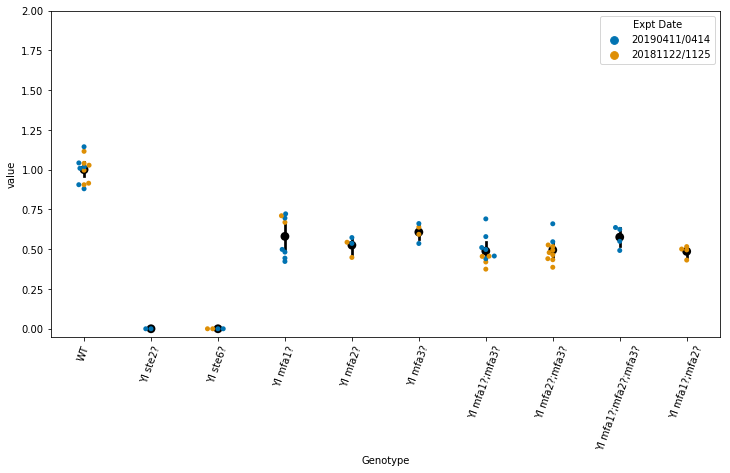

In [9]:
##This is for the plotting of the pheromone deletions, by separating on the appropriate Expt Date since this is going to be the way I do things going forward.
##I am going to Normalize each experiment by the colonies of the ML16507 (keep in mind I need to change the way media is specificied in my RawData (new column?))in that experiment.
sortList = ["20190411/0414","20181122/1125"]
refinedMatingData = pd.DataFrame()
for name in sortList:
    refinedMatingData = refinedMatingData.append(MatingData.groupby(['Expt Date']).get_group(name))

##I am going to use 'Strain', instead of 'plotID' since I am not using plasmids here.
#print(refinedMatingData.iloc[0])
plotRefinedMatingData = refinedMatingData[['Expt Date', 'Strain', 'Genotype', 'Replicate', 'Plate/2e07', 'Plate/1e07', 'Plate/5e06',
                                           'Plate/2e06', 'Plate/1e06']]
meltedPlotRefinedMatingData = pd.melt(plotRefinedMatingData, id_vars=['Expt Date', 'Strain', 'Genotype', 'Replicate'])

test = meltedPlotRefinedMatingData.groupby(['Strain']).get_group("ML16507")
#print(test)
Normalization = {}

for sample in test['Expt Date'].unique():
    #print(sample)
    Normalization.update({sample: test.groupby(['Expt Date']).get_group(sample)['value'].mean()})

#print(Normalization)

for index in list(meltedPlotRefinedMatingData.index.values):
    meltedPlotRefinedMatingData.loc[index, 'value'] /= Normalization[meltedPlotRefinedMatingData.loc[index, 'Expt Date']]

#print(meltedPlotRefinedMatingData.groupby(['plotID']).get_group("E05973/yali005"))

fig1 = figure(figsize=(12,6))
ax1 = sns.pointplot(x="Strain", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="Strain", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating-v2.pdf', dpi=300, transparent=True)

fig2 = figure(figsize=(12,6))
ax2 = sns.boxplot(x="Strain", y="value", data=meltedPlotRefinedMatingData, color="grey", width=0.5)
ax2.set(yscale='linear')
ax2.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating-v2_box-plot_190124.pdf', dpi=300, transparent=True)

fig3 = figure(figsize=(12,6))
ax1 = sns.pointplot(x="Genotype", y="value", data=meltedPlotRefinedMatingData, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="Genotype", y="value", hue="Expt Date", data=meltedPlotRefinedMatingData, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating_190506.pdf', dpi=300, transparent=True)

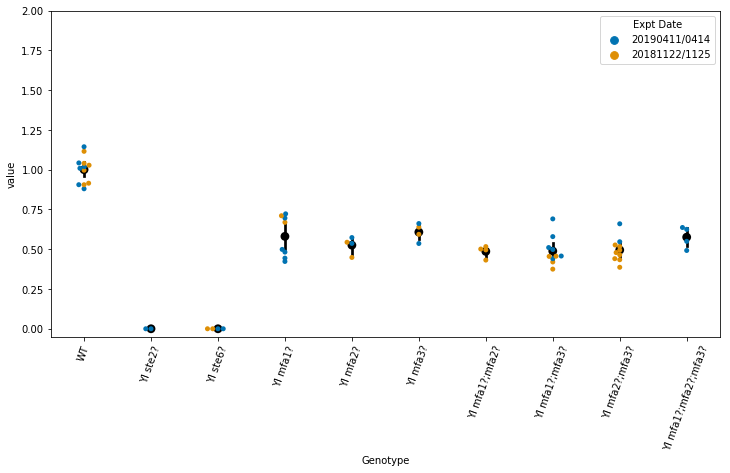

In [12]:
##I am going to re-order the plotted samples to make sense.
fig_file = root_dir+'/ML16507_Pher-deletions_190507.csv'
#print(fig_file)
with open(fig_file, mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    plotSamples = [rows[0] for rows in reader]
#print(plotSamples[0])
#print(plotData[plotData.Sample.isin([plotSamples[0]])])

#print(plotSamples)
plotRefinedMatingDataReorder = pd.DataFrame()
for label in plotSamples:
    plotRefinedMatingDataReorder = plotRefinedMatingDataReorder.append(meltedPlotRefinedMatingData.groupby(['Genotype']).get_group(label))
#print(plotRefinedMatingDataReorder)

fig4 = figure(figsize=(12,6))
ax1 = sns.pointplot(x="Genotype", y="value", data=plotRefinedMatingDataReorder, color="black", marker="d", join=False)
ax1 = sns.swarmplot(x="Genotype", y="value", hue="Expt Date", data=plotRefinedMatingDataReorder, palette="colorblind")
ax1.set(yscale='linear')
ax1.set_ylim(top=2.0, bottom=-0.05)
plt.xticks(rotation=70)
#savefig(root_dir+'/ML16507-Pher-del_filter-mating_190506.pdf', dpi=300, transparent=True)